In [1]:
import os
import sys
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, VotingClassifier

from sklearn.metrics import (accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)

import matplotlib.pyplot as plt
import seaborn as sns

# add src to path so we can import our data module
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(os.path.join(project_root, "src"))

from data.load_data import download_creditcard_data, load_creditcard_df

# Project step 2: Grid search and ensembles on credit card fraud

In this notebook we apply grid search to our baseline models and we build ensemble models.
We work on the same credit card fraud dataset as in project step 1.


In [ ]:
# we download the data (if already downloaded this does nothing important)
download_creditcard_data()
df = load_creditcard_df()

df = df.drop_duplicates().reset_index(drop=True)

X = df.drop("Class", axis=1)
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42,)

# we check class balance on train and test
print("Train class distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest class distribution:")
print(y_test.value_counts(normalize=True))

Train class distribution:
Class
0    0.998335
1    0.001665
Name: proportion, dtype: float64

Test class distribution:
Class
0    0.998326
1    0.001674
Name: proportion, dtype: float64


In [3]:
# we scale only Time and Amount and keep PCA components as they are
numeric_to_scale = ["Time", "Amount"]
other_features = [col for col in X.columns if col not in numeric_to_scale + ["Class"]]

preprocessor = ColumnTransformer(
    transformers=[
        ("scale_time_amount", StandardScaler(), numeric_to_scale),
        ("pass_others", "passthrough", other_features),
    ]
)

## 1. Grid search on baseline models

We tune two baseline models:
- a Decision Tree with class weights for imbalance
- a Logistic Regression with class weights

We use F1 score for the fraud class as the main objective in the grid search.

In [ ]:
# Grid search for decision tree
dt_pipe = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", DecisionTreeClassifier(class_weight="balanced", random_state=42)),
    ]
)

param_grid_dt = {
    "model__criterion": ["gini", "entropy", "log_loss"],
    "model__max_depth": [3, 5, 7, 9, None],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
}

grid_dt = GridSearchCV(
    estimator=dt_pipe,
    param_grid=param_grid_dt,
    scoring="f1",
    cv=3,
    n_jobs=-1,
    verbose=1,
)

grid_dt.fit(X_train, y_train)

print("Best Decision Tree params:")
print(grid_dt.best_params_)
print(f"Best CV F1 score: {grid_dt.best_score_:.4f}")

best_dt = grid_dt.best_estimator_

y_pred_dt = best_dt.predict(X_test)
y_proba_dt = best_dt.predict_proba(X_test)[:, 1]

print("\nDecision Tree classification report (test):")
print(classification_report(y_test, y_pred_dt, digits=4))

Fitting 3 folds for each of 135 candidates, totalling 405 fits
Best Decision Tree params:
{'model__criterion': 'entropy', 'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5}
Best CV F1 score: 0.7553

Decision Tree classification report (test):
              precision    recall  f1-score   support

           0     0.9995    0.9998    0.9996     56651
           1     0.8312    0.6737    0.7442        95

    accuracy                         0.9992     56746
   macro avg     0.9153    0.8367    0.8719     56746
weighted avg     0.9992    0.9992    0.9992     56746



In [10]:
# Grid search for Logistic Regression
lr_pipe = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", LogisticRegression(class_weight="balanced", max_iter=1000)),
    ]
)

param_grid_lr = {
    "model__C": [0.01, 0.1, 1, 10],
    "model__penalty": ["l2"],
    "model__solver": ["liblinear", "lbfgs"],
}

grid_lr = GridSearchCV(
    estimator=lr_pipe,
    param_grid=param_grid_lr,
    scoring="f1",
    cv=3,
    n_jobs=-1,
    verbose=1,
)

grid_lr.fit(X_train, y_train)

print("Best Logistic Regression params:")
print(grid_lr.best_params_)
print(f"Best CV F1 score: {grid_lr.best_score_:.4f}")

best_lr = grid_lr.best_estimator_

y_pred_lr = best_lr.predict(X_test)
y_proba_lr = best_lr.predict_proba(X_test)[:, 1]

print("\nLogistic Regression classification report (test):")
print(classification_report(y_test, y_pred_lr, digits=4))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Logistic Regression params:
{'model__C': 0.01, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Best CV F1 score: 0.1146

Logistic Regression classification report (test):
              precision    recall  f1-score   support

           0     0.9998    0.9760    0.9877     56651
           1     0.0575    0.8737    0.1079        95

    accuracy                         0.9758     56746
   macro avg     0.5287    0.9248    0.5478     56746
weighted avg     0.9982    0.9758    0.9863     56746



## 2. Ensemble models: Bagging and Voting

We now build:
- a Bagging ensemble based on a Decision Tree
- a Voting ensemble that combines the tuned Decision Tree and the tuned Logistic Regression

We keep the same train and test sets as before.

In [12]:
bag_dt_pipe = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        (
            "model",
            BaggingClassifier(
                estimator=DecisionTreeClassifier(
                    class_weight="balanced",
                    random_state=42,
                ),
                n_estimators=50,
                max_samples=0.8,
                n_jobs=-1,
                random_state=42,
            ),
        ),
    ]
)

bag_dt_pipe.fit(X_train, y_train)

y_pred_bag = bag_dt_pipe.predict(X_test)
y_proba_bag = bag_dt_pipe.predict_proba(X_test)[:, 1]

print("Bagging Decision Tree classification report (test):")
print(classification_report(y_test, y_pred_bag, digits=4))

Bagging Decision Tree classification report (test):
              precision    recall  f1-score   support

           0     0.9994    1.0000    0.9997     56651
           1     0.9844    0.6632    0.7925        95

    accuracy                         0.9994     56746
   macro avg     0.9919    0.8316    0.8961     56746
weighted avg     0.9994    0.9994    0.9994     56746



In [13]:
# we build a VotingClassifier from the best pipelines
voting_clf = VotingClassifier(
    estimators=[
        ("dt", best_dt),
        ("lr", best_lr),
    ],
    voting="soft",
)

voting_clf.fit(X_train, y_train)

y_pred_vote = voting_clf.predict(X_test)
y_proba_vote = voting_clf.predict_proba(X_test)[:, 1]

print("Voting ensemble classification report (test):")
print(classification_report(y_test, y_pred_vote, digits=4))

Voting ensemble classification report (test):
              precision    recall  f1-score   support

           0     0.9995    0.9998    0.9996     56651
           1     0.8312    0.6737    0.7442        95

    accuracy                         0.9992     56746
   macro avg     0.9153    0.8367    0.8719     56746
weighted avg     0.9992    0.9992    0.9992     56746



In [14]:
def compute_metrics(y_true, y_pred, y_proba, name):
    return {
        "model": name,
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_true, y_proba),
    }

results = []

results.append(compute_metrics(y_test, y_pred_dt, y_proba_dt, "DecisionTree (tuned)"))
results.append(compute_metrics(y_test, y_pred_lr, y_proba_lr, "LogisticRegression (tuned)"))
results.append(compute_metrics(y_test, y_pred_bag, y_proba_bag, "Bagging DT"))
results.append(compute_metrics(y_test, y_pred_vote, y_proba_vote, "Voting (DT + LR)"))

results_df = pd.DataFrame(results)
results_df

,model,accuracy,precision,recall,f1,roc_auc
0,DecisionTree (tuned),0.999225,0.831169,0.673684,0.744186,0.836763
1,LogisticRegression (tuned),0.975822,0.057519,0.873684,0.107932,0.965425
2,Bagging DT,0.999418,0.984375,0.663158,0.792453,0.930556
3,Voting (DT + LR),0.999225,0.831169,0.673684,0.744186,0.965520


## 3. Confusion matrices and score comparison

We now compare the models with confusion matrices and a bar plot of F1 scores.
We focus on the fraud class because it is the minority and the most important in this project.

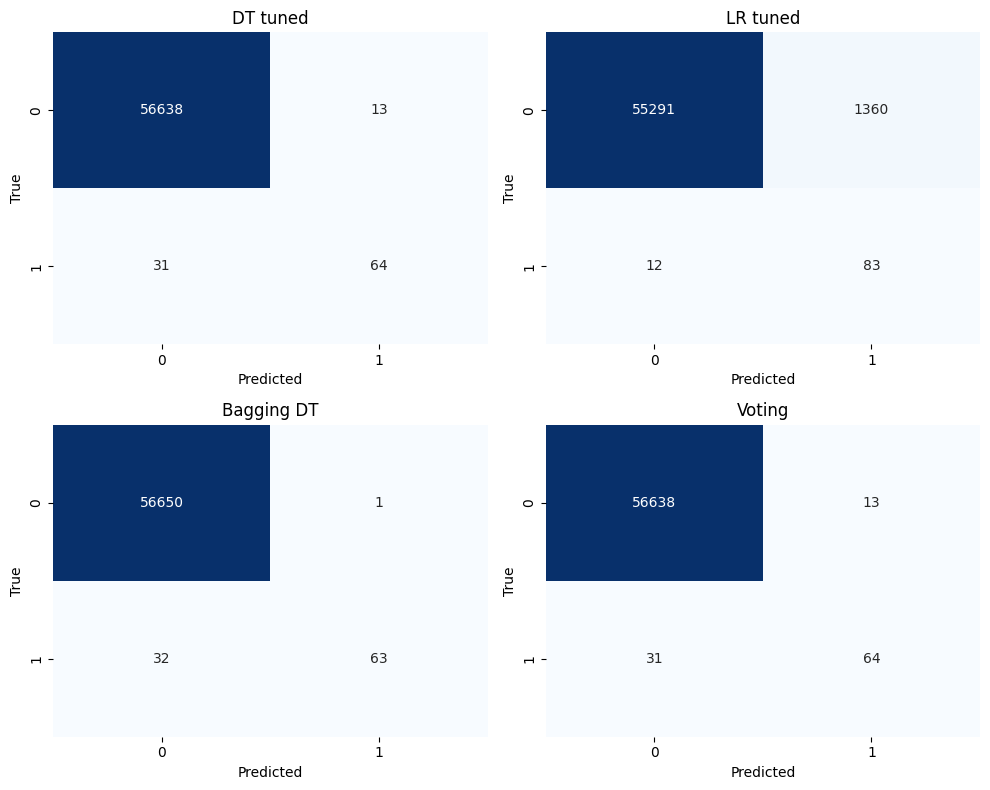

In [15]:
models_preds = {
    "DT tuned": y_pred_dt,
    "LR tuned": y_pred_lr,
    "Bagging DT": y_pred_bag,
    "Voting": y_pred_vote,
}

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

for ax, (name, y_pred) in zip(axes, models_preds.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        ax=ax,
    )
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

plt.tight_layout()
plt.show()

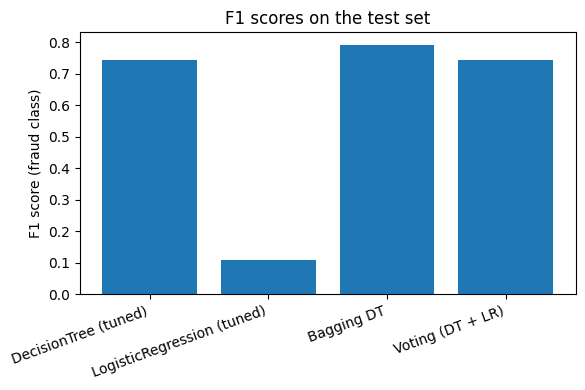

In [16]:
plt.figure(figsize=(6, 4))
plt.bar(results_df["model"], results_df["f1"])
plt.xticks(rotation=20, ha="right")
plt.ylabel("F1 score (fraud class)")
plt.title("F1 scores on the test set")
plt.tight_layout()
plt.show()

## 4. Conclusion

We see that Bagging DT has the best F1 score (around 0.79) and very high precision (almost no false positives). Recall is close to the tuned Decision Tree, so we still detect many frauds.

The tuned Logistic Regression has the best recall and the best ROC AUC, but its precision is very low. The confusion matrix shows many false positives, so this model would send a lot of wrong alerts.

The tuned Decision Tree and the Voting model are in the middle: they have good F1 scores and a more balanced trade off between recall and precision.

For this project we can say that Bagging DT gives the best trade off between catching frauds and avoiding too many false alerts.